# EXPLORATION 08

# 8. 인물사진을 만들어 보자

* Writier : 송영석
* Date : 2021.10.19

## 1. 인물모드 사진을 성공적으로 제작
본인의 인물모드, 고양이 그리고 배경전환

In [11]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [12]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_path_flower = os.getenv('HOME')+'/aiffel/human_segmentation/images/flower.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
 

img_orig = cv2.imread(img_path) 
img_cat = cv2.imread(img_path_cat) 
img_flower =  cv2.imread(img_path_flower)

print ("me:",img_orig.shape)
print("cat:",img_cat.shape)
print("flower:",img_flower.shape)

me: (1302, 1207, 3)
cat: (1440, 648, 3)
flower: (427, 640, 3)


### DeepLab 모델
구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.

In [13]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        print(target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})
        

        seg_map = batch_seg_map[0]
        print(seg_map)
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 사전에 학습된 가중치(pretrained weight)

In [14]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [15]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

img_resized_cat, seg_map_cat = MODEL.run(img_cat)
print (img_cat.shape, img_resized.shape, seg_map.max())

(475, 513)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1302, 1207, 3) (513, 475, 3) 15
(230, 513)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1440, 648, 3) (513, 475, 3) 15


In [16]:
#구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다.
#제공하는 라벨 종류는 아래와 같습니다.

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

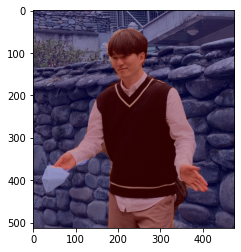

In [17]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 15 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

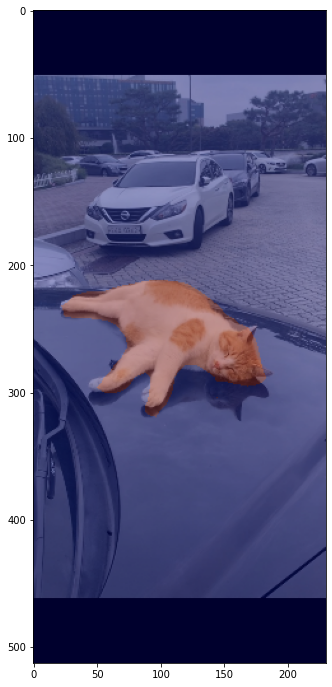

In [18]:
img_show_cat = img_resized_cat.copy()
seg_map_cat = np.where(seg_map_cat == 8, 8, 0) # 예측 중 8 고양이만 추출
img_mask_cat = seg_map_cat * (255/seg_map_cat.max()) # 255 normalization
img_mask_cat = img_mask_cat.astype(np.uint8)
color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask_cat, 0.35, 0.0)
plt.figure(figsize=(20,12))
plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

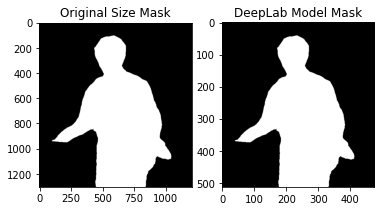

In [19]:
# DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력
#  출력도 resize 된 입력 크기와 같게 나오게 됩니다
# 세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

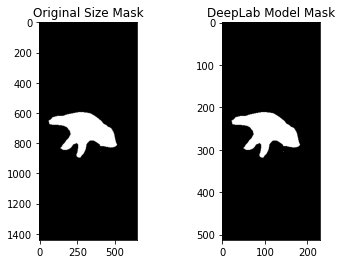

In [20]:

img_mask_up_cat = cv2.resize(img_mask_cat, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_cat, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

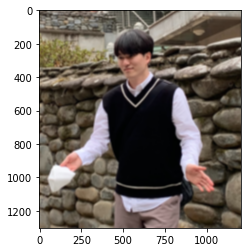

In [21]:
#  배경을 흐리게 만듭니다.
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

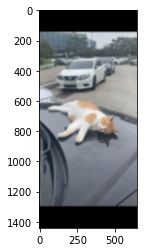

In [22]:
img_cat_blur = cv2.blur(img_cat, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

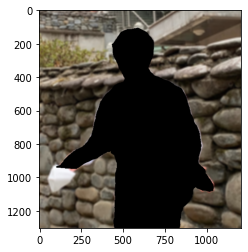

In [23]:
# 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

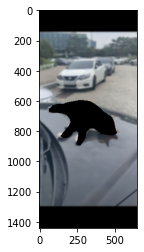

In [24]:
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_blur_cat = cv2.bitwise_and(img_cat_blur, img_bg_mask_cat)
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 인물과 고양이에 흐린 배경 합성 성공

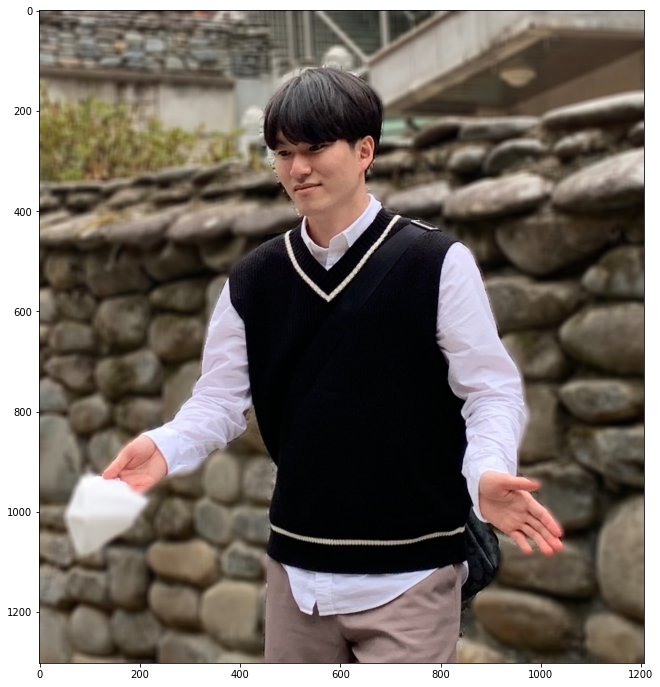

In [25]:
#배경 영상과 사람 영상을 합치기
plt.figure(figsize=(15,12))
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

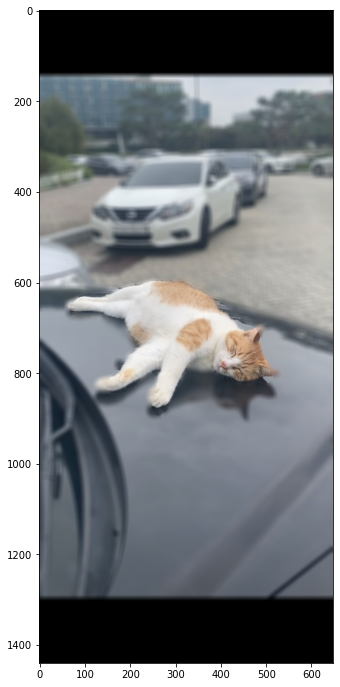

In [26]:
plt.figure(figsize=(20,12))
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))

plt.show()


### 배경이미지를 이용해 꽃밭에 누운 고양이 만들기

(427, 640, 3)


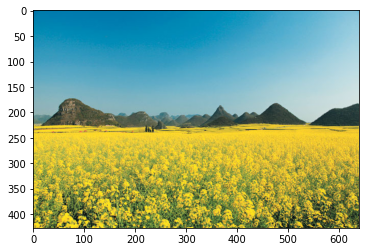

In [27]:
# 배경 이미지
print(img_flower.shape)
img_flower_rgb = cv2.cvtColor(img_flower, cv2.COLOR_BGR2RGB)
plt.imshow(img_flower_rgb)
plt.show()

In [28]:
#이미지 사이즈 조절
target_size = (img_cat.shape[1], img_cat.shape[0])
img_flower_resized = cv2.resize(img_flower, target_size) 
print(img_flower_resized.shape)
print(img_cat.shape)

(1440, 648, 3)
(1440, 648, 3)


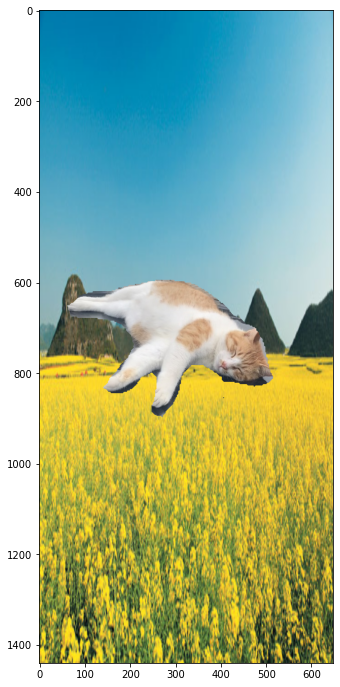

In [29]:
# 합성 

img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_concat_flower = np.where(img_mask_color_cat==255, img_cat,img_flower_resized)
plt.figure(figsize=(20,12))
plt.imshow(cv2.cvtColor(img_concat_flower, cv2.COLOR_BGR2RGB))
plt.show()

##  2. 제작한 인물모드 사진들에서 나타나는 문제점

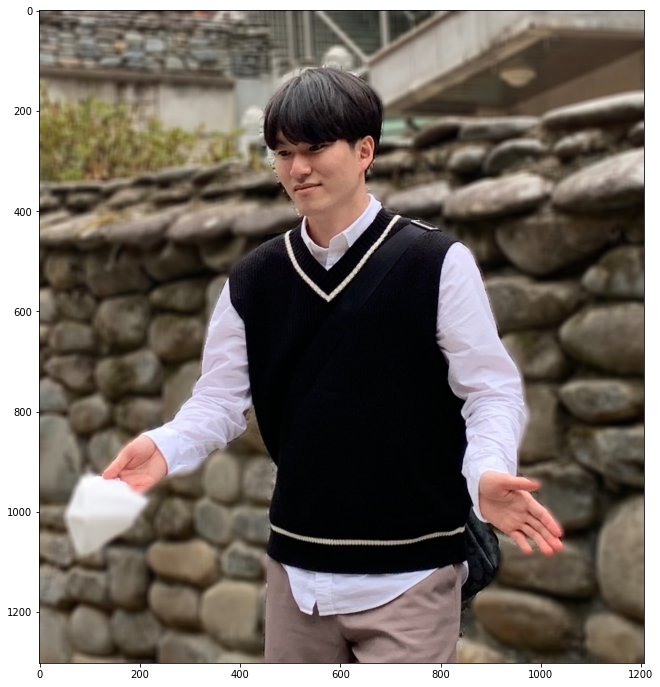

In [30]:
plt.figure(figsize=(15,12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 인물사진 문제점
뒤에 매고 있는 가방또한 인물이 아니므로 마스크와 같이 blur처리가 되었어야하지만 옷으로 인식한게 아닌가 생각하고 있습니다.   
손 끝이 같이 조금 blur 된것이 blur가 조금 번져 보이며 경계선 처리가 잘 안된 것 같았습니다.

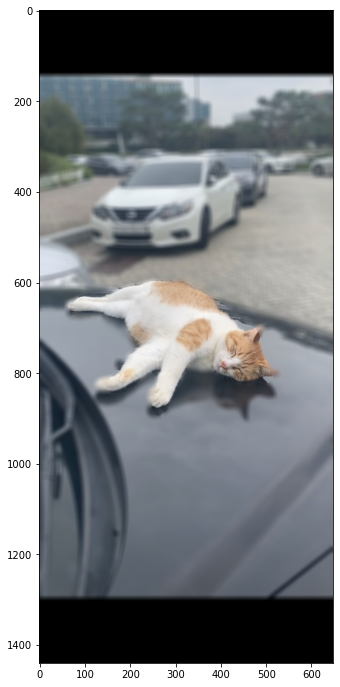

In [31]:
plt.figure(figsize=(20,12))
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))

plt.show()

### 고양이 사진 문제점
배경은 잘 blur처리 되었지만 고양이의 발부분에 blur가 조금 되어 잘 구분 되어있지 않은 문제점이 있었습니다. 고양이 자체는 분리할 때 발바닥 같이 세세한 부분도 정확히 잡아내야 할 것 같습니다.

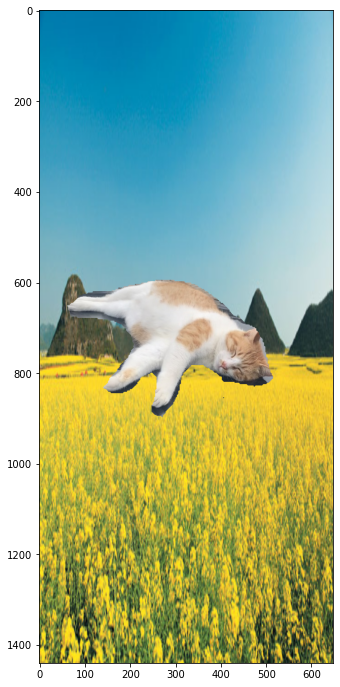

In [32]:
plt.figure(figsize=(20,12))
plt.imshow(cv2.cvtColor(img_concat_flower, cv2.COLOR_BGR2RGB))
plt.show()

### 배경사진 문제점
꽃밭배경에 고양이가 잘 들어가 있어야 하지만 경계 부분이 정확히 고양이를 잘라내지 못하여서 배경의 일부가 같이 합성되었습니다.  
고양이의 경계를 조금 더 정확히 잘라내면 매끄러운 사진이 될 것 같습니다.

##  3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션

1. 첫번째 본인의 인물사진에서는 아웃 포커싱 처럼 되는 것이 아니라 배경에 붕떠있는듯한 느낌을 주게 되는 것을 해결 해야합니다.   
카메라 2대로 얻어내는 3D Depth를 이용해 이미지를 직접 가공(보정)하여 가방이 인물과는 분리되어 있다는 정보를 심을 수 있을 것 같습니다. (고양이 사진도 동일)

2. 밑의 고양이 배경 사진에는 좀 더 꽃밭에 어우러져 있는 것처럼 만들어지면 좋겠다는 것에 초점을 두고 해결책을 생각해봤습니다.  
이 사진이 부자연 스러워 보이는 이유는 고양이가 완벽하지 않아서 라기보다는 주변에 배경이 같이 segmentation되어서라고 생각합니다.  
따라서 segmentation할때에 고양이 주변 테두리를 조금 더 넓게 잘라온 지금과는 달리 오히려 고양이 테두리를 더 안쪽으로 (고양이 일부가 잘리더라도) 하는 방식의 segmentation을 하면 더 자연스럽게 배경이 입혀질거 같다고 생각했습니다.

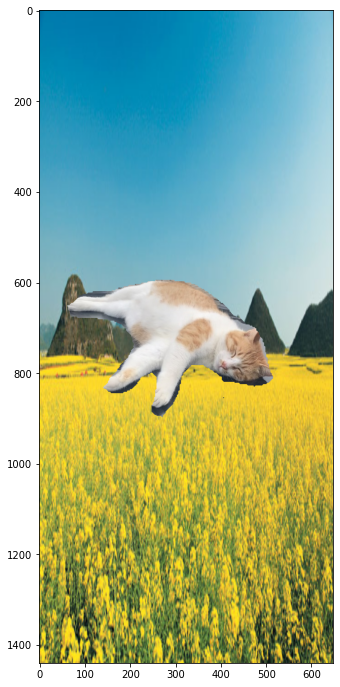

In [33]:
plt.figure(figsize=(20,12))
plt.imshow(cv2.cvtColor(img_concat_flower, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

1. NLP에 관심은 늘 더 있지만 CV프로젝트가 확실히 결과물 보는 재미가 늘 있어서 흥미로운 것 같습니다.
2. 이미지를 다루는 방법이 여러가지 있는 것을 하나씩 얻어가는 것이 보람 차지만 조금 더 서로간의 체계를 정리해서 공부해야한다고 느꼈습니다.
3. 문제점은 명확하나 개선하는 솔루션의 더 멋진 제시와 그리고 실행해 보지 못한 점이 너무나 아쉬웠습니다.
